In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from terminal_optimization import hydrogen_objects
from terminal_optimization import hydrogen_defaults
from terminal_optimization import hydrogen_system

# 0. Prepare inputs

In [2]:
startyear = 2018
lifecycle = 10

## 0.1 Generate demand forecast scenario

In [3]:
years = list(range(startyear, startyear+lifecycle))

demand = []
for year in years:
    if year < 2023:
        demand.append(750_000)
    else:
        demand.append(1_600_000)

scenario_data={'year': years, 'volume': demand}

# instantiate a commodity objects
# maize
# hydrogen_defaults.lhydrogen_data['smallhydrogen_perc'] = 50
# hydrogen_defaults.lhydrogen_data['largehydrogen_perc'] = 50
# hydrogen_defaults.lhydrogen_data['smallammonia_perc'] = 0
# hydrogen_defaults.lhydrogen_data['largeammonia_perc'] = 0
# hydrogen_defaults.lhydrogen_data['handysize_perc'] = 0
# hydrogen_defaults.lhydrogen_data['panamax_perc'] = 0
# hydrogen_defaults.lhydrogen_data['vlcc_perc'] = 0
# hydrogen_defaults.lhydrogen_data['handling_fee'] = 9.8 # example Wijnand
# hydrogen_defaults.lhydrogen_data['historic_data'] = []
lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.lhydrogen_data)
lhydrogen.scenario_data = pd.DataFrame(data=scenario_data)

# wheat
hydrogen_defaults.ammonia_data['historic_data'] = []
hydrogen_defaults.ammonia_data['scenario_data'] = []
ammonia = hydrogen_objects.Commodity(**hydrogen_defaults.ammonia_data)

# soybeans
hydrogen_defaults.MCH_data['historic_data'] = []
hydrogen_defaults.MCH_data['scenario_data'] = []
MCH = hydrogen_objects.Commodity(**hydrogen_defaults.MCH_data)

# combine
demand = [lhydrogen, ammonia, MCH]

# plot scenarios 
if False:
    lhydrogen.plot_demand()
    ammonia.plot_demand()
    MCH.plot_demand()

## 0.2 Generate vessels

In [4]:
# instantiate vessels
Smallhydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.smallhydrogen_data)
Largehydrogen = hydrogen_objects.Vessel(**hydrogen_defaults.largehydrogen_data)
Smallammonia = hydrogen_objects.Vessel(**hydrogen_defaults.smallammonia_data)
Largeammonia = hydrogen_objects.Vessel(**hydrogen_defaults.largeammonia_data)
Handysize = hydrogen_objects.Vessel(**hydrogen_defaults.handysize_data)
Panamax = hydrogen_objects.Vessel(**hydrogen_defaults.panamax_data)
VLCC = hydrogen_objects.Vessel(**hydrogen_defaults.vlcc_data)


vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

# 1. Instatiate terminal system

In [5]:
Terminal = hydrogen_system.System(startyear = startyear, 
                         lifecycle = lifecycle, 
                         elements = demand + vessels, 
                         operational_hours = 5840,   # example Wijnand
                         debug=True,
                         crane_type_defaults=hydrogen_defaults.mobile_crane_data, 
                         storage_type_defaults=hydrogen_defaults.storage_lh2_data)

# 2. Start simulation
Develop terminal given the throughput scenario and investment triggers implemented

In [6]:
Terminal.simulate()


Simulate year: 2018
  Total vessel calls: 41
     Small Hydrogen  calls: 23
     Large Hydrogen calls: 18
     Small ammonia calls: 0
     Large ammonia calls: 0
     Handysize calls: 0
     Panamax calls: 0
     VLCC calls: 0
  Total cargo volume: 750000
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned
     a total of 0 [] is online; 0 total planned

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online (@ start of year): inf
     Crane occupancy planned (@ start of year): inf
     Crane occupancy online (@ start of year): inf
     waiting time factor (@ start of year): inf
     waiting time occupancy (@ start of year): inf
  *** add Berth to elements
     Be

  *** add jetty pipeline to elements
     a total of 1200 ton of pipeline_jetty service capacity is online; 2800 ton total planned
     a total of 240000 ton of HydrogenTank storage capacity is online; 240000 ton total planned
     a total of 800 ton of pipeline hinterland service capacity is online; 800 ton total planned
     a total of 800 ton of pipeline hinterland service capacity is online; 800 ton total planned
     Station occupancy planned (@ start of year): 0.5016225321409993
     Station occupancy online (@ start of year): 0.5016225321409993
     Number of trains (@start of year): 450.0
  *** add station to elements

Simulate year: 2024
  Total vessel calls: 86
     Small Hydrogen  calls: 48
     Large Hydrogen calls: 38
     Small ammonia calls: 0
     Large ammonia calls: 0
     Handysize calls: 0
     Panamax calls: 0
     VLCC calls: 0
  Total cargo volume: 1600000
     a total of 2 Berth_01 is online; 2 total planned
     a total of 1 Quay_01 is online; 2 total planned
 

PV: [-1.57563600e+07 -1.69060794e+14 -2.97725034e+12 -2.62154207e+12
 -2.30833209e+12 -2.03254978e+12 -1.78970555e+12 -1.57587057e+12
 -1.38759135e+12 -1.22180680e+12]
NPV: -184975458450848.4


## Report all elements

In [7]:
if False: 
    for element in Terminal.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__)

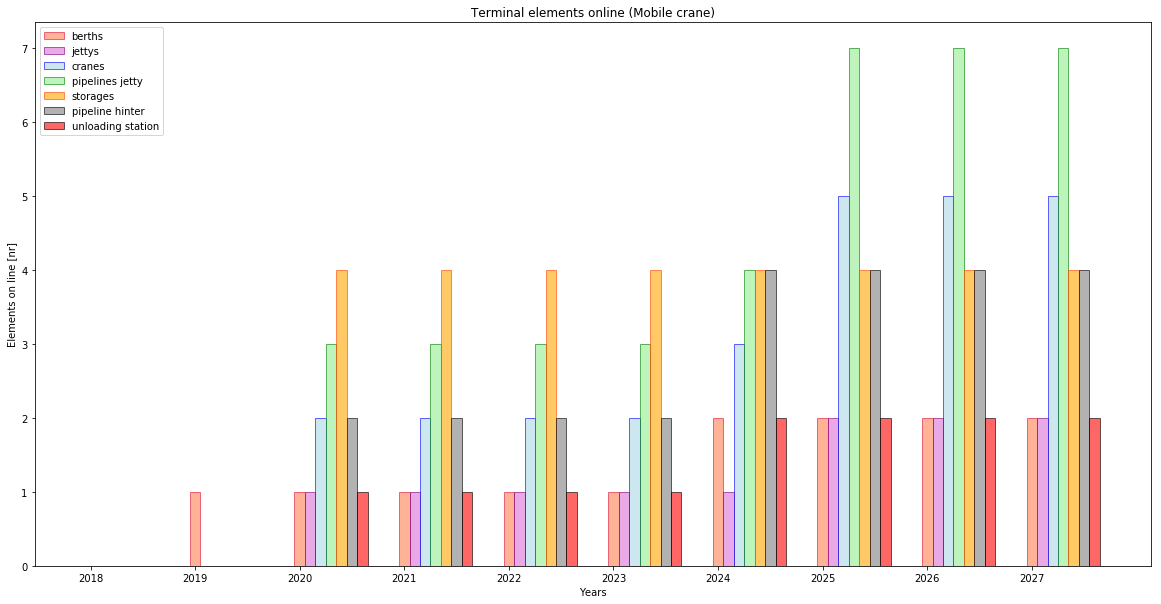

In [8]:
Terminal.terminal_elements_plot()

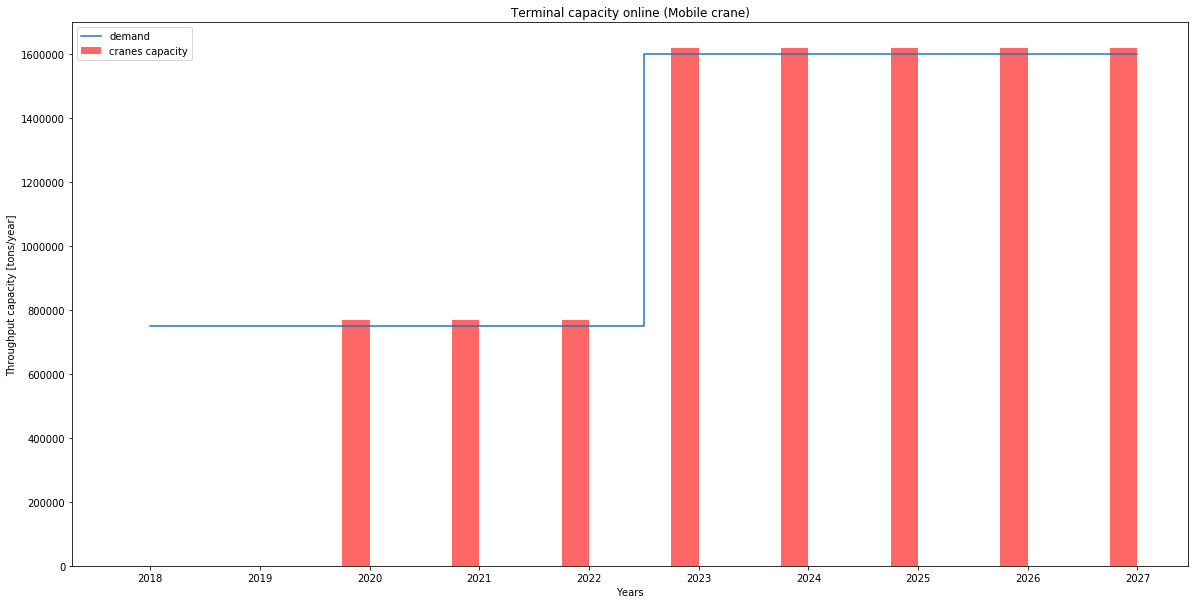

In [9]:
Terminal.terminal_capacity_plot()

In [10]:
# add cash flow information for each of the Terminal elements
cash_flows, cash_flows_WACC_real = Terminal.add_cashflow_elements()

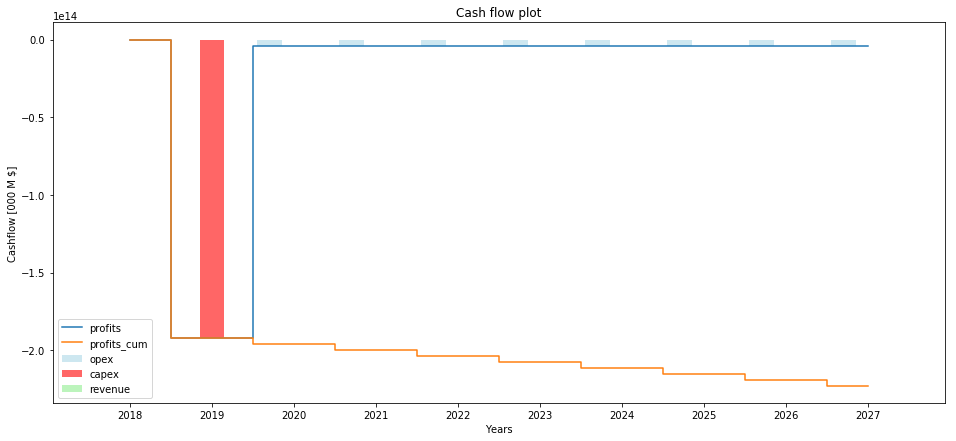

In [11]:
Terminal.cashflow_plot(cash_flows)

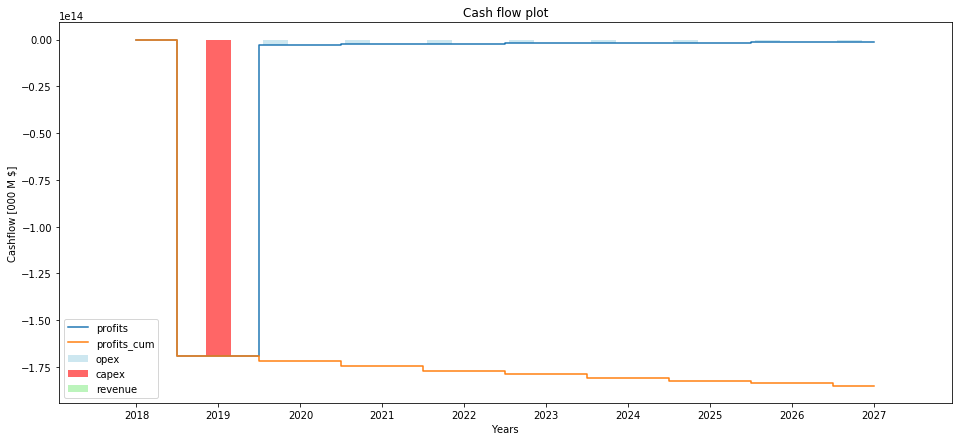

In [12]:
Terminal.cashflow_plot(cash_flows_WACC_real)

## SandBox

In [13]:
Terminal.NPV()

PV: [-1.57563600e+07 -1.69060794e+14 -2.97725034e+12 -2.62154207e+12
 -2.30833209e+12 -2.03254978e+12 -1.78970555e+12 -1.57587057e+12
 -1.38759135e+12 -1.22180680e+12]
NPV: -184975458450848.4
